# Differentiable DCT-II Based Resampling

As part of an experiment with audio generation, I'd like to produce an audio signal at many different scales, upsample each band to the final, output sampling rate, and add them all together.  

Put another way, I'd like to generate many different frequency bands somewhat independently, and linearlly combine them to produce the output signal.

This is very straightforward to do using something like [`scipy.signal.resample`](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.resample.html).  It uses FFT-based resampling, which is very straightforward, and goes something like this:

1. Given the desired output sample size, determine how many FFT coefficients would be required to analyze/synthesize that new signal
1. Take the FFT of the original signal, and then expand (pad with zeros) or truncate the coefficients such that they have the same number of FFT coefficients we calculated in step one
1. Perform the inverse FFT transform on the expanded/padded or truncated coefficients

I'm interested in using this approach for resampling as part of a neural network architecture because neither of the current available up or down-sampling approaches available in [PyTorch](http://pytorch.org/) really fit the bill.

Let's look and listen to the outcome of using the available methods before we move on to developing our own.

## Up-Sampling

We'll try the two available options for [`torch.nn.functional.upsample`](http://pytorch.org/docs/master/nn.html#torch.nn.functional.upsample):

- `nearest`
- `linear`

First, let's listen to the original signal.

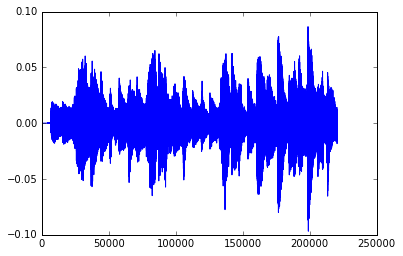

In [17]:
%matplotlib inline
import zounds
from zounds.soundfile import resample
from IPython.display import display, Audio
from matplotlib import pyplot as plt

filepath = '../audio/bach.ogg'
original_samples = zounds.AudioSamples.from_file(filepath).mono
segment = original_samples[:zounds.Seconds(10)]
samples = resample(segment, zounds.SR22050())

plt.plot(samples)
Audio(samples, rate=int(samples.samplerate))

As a baseline, let's use the FFT-based resampling described above

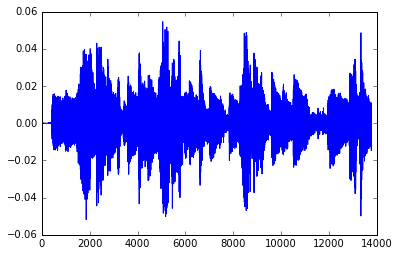

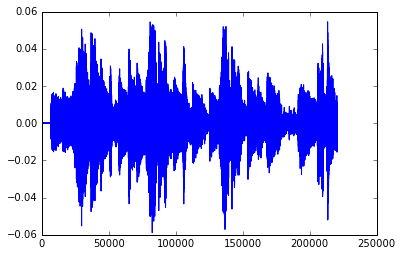

In [18]:
from scipy.signal import resample as baseline_resample

# downsample, effectively applying a low-pass filter
downsampled = baseline_resample(samples, int(len(samples) * 0.0625))
plt.plot(downsampled)
plt.show()

# upsample to the original sampling rate
upsampled = baseline_resample(downsampled, len(samples))
plt.plot(upsampled)
plt.show()

Audio(upsampled, rate=int(samples.samplerate))

Now that we understand the basic structure of our experiments, let's write some wrappers for the functions we'll be evaluating so that they share a common interface, and then write a little driver for our experiments.

In [19]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable


def scipy_resample(signal, factor, axis):
    """
    Use the FFT-based resampling from scipy to 
    up or downsample
    """
    n_samples = int(signal.shape[axis] * factor)
    return baseline_resample(signal, n_samples, axis=axis)

def pytorch_wrapper(func):
    """
    Decorator that handles shuttling data between numpy
    and pytorch representations
    """
    
    def to_variable(maybe_arr):
        try:
            tensor = torch.from_numpy(maybe_arr).float()
            return Variable(tensor)
        except RuntimeError:
            return maybe_arr
    
    def from_variable(output):
        try:
            return output.data.cpu().numpy()
        except AttributeError:
            return output
    
    def x(*args, **kwargs):
        transformed_args = [to_variable(arg) for arg in args]
        transformed_kwargs = dict(
            (k, to_variable(v)) for k, v in kwargs.iteritems())
        result = func(*transformed_args, **transformed_kwargs)
        return from_variable(result)
    
    return x

def pytorch_downsample(signal, factor, func, axis=-1):
    original_samples = signal.shape[axis]
    new_size = int(original_samples * factor)
    kernel_size = original_samples // new_size
    x = func(signal, kernel_size)
    return x

@pytorch_wrapper
def pytorch_downsample_avg(signal, factor, axis=-1):
    """
    http://pytorch.org/docs/master/nn.html#torch.nn.functional.avg_pool1d
    """
    return pytorch_downsample(
        signal, factor, F.avg_pool1d, axis=axis)

@pytorch_wrapper
def pytorch_downsample_max(signal, factor, axis=-1):
    """
    http://pytorch.org/docs/master/nn.html#torch.nn.functional.max_pool1d
    """
    return pytorch_downsample(
        signal, factor, F.max_pool1d, axis=axis)

@pytorch_wrapper
def pytorch_upsample_nearest(signal, factor, axis=-1):
    """
    http://pytorch.org/docs/master/nn.html#torch.nn.functional.upsample
    using mode "nearest"
    """
    return F.upsample(signal, scale_factor=factor, mode='nearest')

@pytorch_wrapper
def pytorch_upsample_linear(signal, factor, axis=-1):
    """
    http://pytorch.org/docs/master/nn.html#torch.nn.functional.upsample
    using mode "linear"
    """
    return F.upsample(signal, scale_factor=factor, mode='linear')


def resample_evaluation(signal, factor, downsample, upsample):
    # adopt the pytorch convention of (examples x channels x size)
    signal = signal.reshape((-1, 1, signal.shape[-1]))
    
    downsampled = downsample(signal, factor, axis=-1)
    plt.plot(downsampled.squeeze())
    plt.show()
    
    upsampled = upsample(downsampled, int(1. / factor), axis=-1).squeeze()
    plt.plot(upsampled)
    plt.show()
    return upsampled

### Nearest-Neighbor Up-Sampling

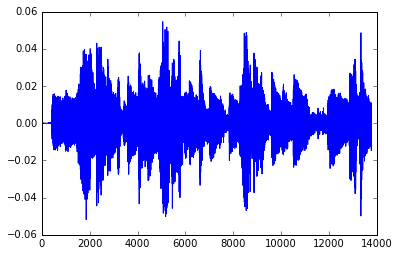

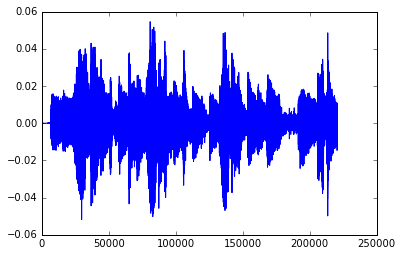

In [20]:
upsampled = resample_evaluation(
    signal=samples, 
    factor=0.0625, 
    downsample=scipy_resample, 
    upsample=pytorch_upsample_nearest)
Audio(upsampled, rate=int(samples.samplerate))

### Linear Up-Sampling

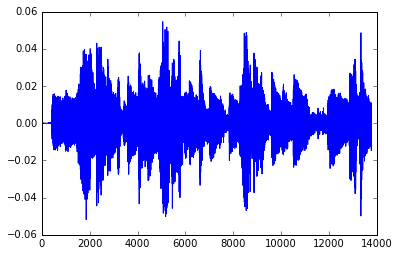

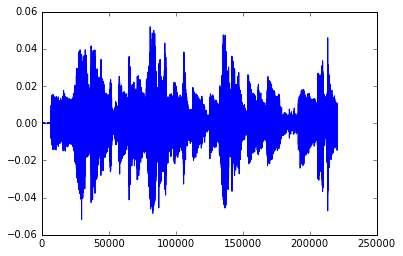

In [21]:
upsampled = resample_evaluation(
    signal=samples, 
    factor=0.0625, 
    downsample=scipy_resample, 
    upsample=pytorch_upsample_linear)
Audio(upsampled, rate=int(samples.samplerate))

### Average Pool Downsampling

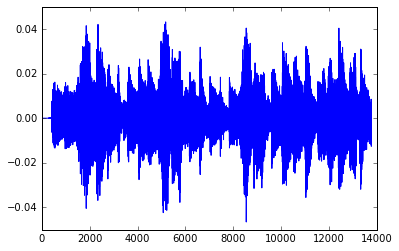

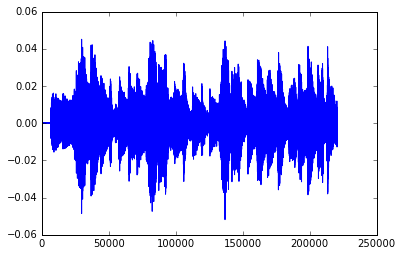

In [22]:
upsampled = resample_evaluation(
    signal=samples, 
    factor=0.0625, 
    downsample=pytorch_downsample_avg, 
    upsample=scipy_resample)
Audio(upsampled, rate=int(samples.samplerate))

### Max Pool Downsampling

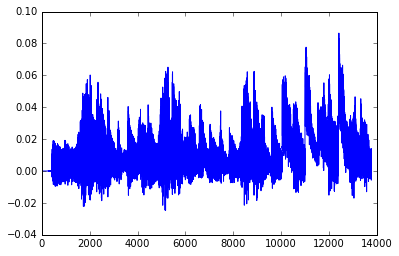

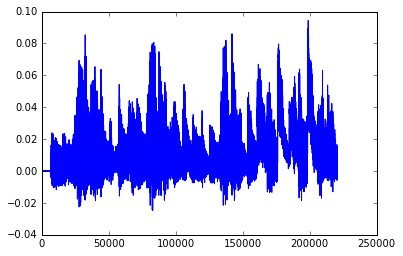

In [23]:
upsampled = resample_evaluation(
    signal=samples, 
    factor=0.0625, 
    downsample=pytorch_downsample_max, 
    upsample=scipy_resample)
Audio(upsampled, rate=int(samples.samplerate))

## DCT-II Resampling

As you can hear, all of the evaluated up and down-sampling methods introduce artifacts in the audio.  Intuitively, none of the methods really make sense for periodic signals, so, we'd like something that:

- can up and down-sample, and assumes the signal is periodic
- is something we can implement in PyTorch, and will be differentiable, so it can be used as a component in a neural network architecture


### NumPy Implementation

First, let's write another implementation of the interface we defined above in numpy that will use the DCT-II transform to do resampling.  

- First, we'll be using [`scipy.fftpack.dct`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.fftpack.dct.html), so we understand the mechanics of how to shuffle the DCT coefficients around
- Then, we'll look under the hood and implement the DCT and inverse DCT ourselves using a simple matrix multiplication.

In [24]:
from scipy.fftpack import dct, idct
import numpy as np


def dct_resample(x, factor, axis=-1):
    n_samples = int(factor * x.shape[axis])
    
    # first, take the dct of the current samples
    coeffs = dct(x, axis=axis, norm='ortho')
    
    # create the shape of our new coefficients
    new_coeffs_shape = list(coeffs.shape)
    new_coeffs_shape[axis] = n_samples
    
    # create an array to hold our new, resampled coefficients
    new_coeffs = np.zeros(new_coeffs_shape)
    
    new_coeffs_slices = [slice(None)] * x.ndim
    new_coeffs_slices[axis] = slice(None, coeffs.shape[axis])
    
    old_coeffs_slices = [slice(None)] * x.ndim
    old_coeffs_slices[axis] = slice(None, new_coeffs.shape[axis])

    new_coeffs[new_coeffs_slices] = coeffs[old_coeffs_slices]
    
    # reconstruct the samples
    new_samples = idct(new_coeffs, norm='ortho')
    return new_samples

### DCT-II Up and Downsampling

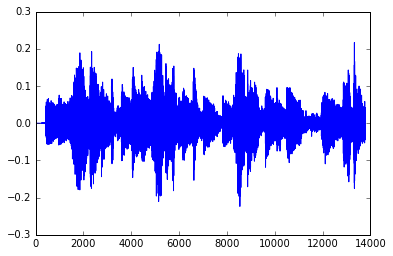

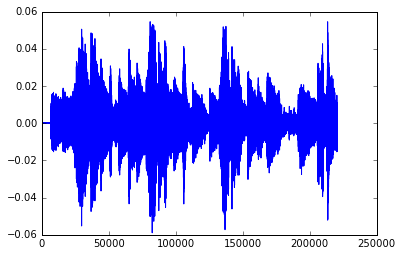

In [25]:
upsampled = resample_evaluation(
    signal=samples, 
    factor=0.0625, 
    downsample=dct_resample, 
    upsample=dct_resample)
Audio(upsampled, rate=int(samples.samplerate))

Unsurprisingly, this approach is on par with the FFT-based approach from scipy.  The only difference is that we're using the DCT transform, instead of an FFT.

If we want this to be differentiable, and to use it easily as part of a neural network architecture, we'll need to move the actual computation of the transform out of numpy, and into PyTorch.  

Luckliy, the transform is nothing more than a matrix multiplication with a carefully designed basis matrix.  Let's take a look at the matrix:

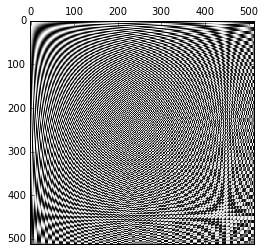

In [26]:
from zounds.spectral import dct_basis
plt.matshow(dct_basis(512), cmap='gray')

All we need to do is to move the basis matrix into a PyTorch [`FloatTensor`](http://pytorch.org/docs/master/tensors.html), and then use [`torch.matmul`](http://pytorch.org/docs/master/torch.html#torch.matmul), and we've implemented the forward transform!

Even cooler, we can perform the inverse tranform by taking the matrix product of the DCT coefficients with the transpose of the basis!

Let's write a few functions to get the basis into pytorch, and to perform the forward and inverse transforms.  Let's also memoize the new function for creating a dct basis, as it will likely be called for the same size input many times.

In [27]:
from torch.autograd import Variable


class memoize(object):
    """
    A very naive memoize decorator that can
    only decorate functions with a single, hashable
    argument
    """
    def __init__(self, func):
        super(memoize, self).__init__()
        self._func = func
        self._cache = dict()
    
    def __call__(self, arg):
        try:
            return self._cache[arg]
        except KeyError:
            v = self._func(arg)
            self._cache[arg] = v
            return v

@memoize
def pytorch_dct_basis(n):
    return torch.from_numpy(dct_basis(n)).float()

def pytorch_base_dct_transform(x, basis, axis=-1):
    n = torch.FloatTensor(1)
    n[:] = 2. / x.shape[axis]
    n = Variable(n)
    coeffs = torch.matmul(x, basis) * torch.sqrt(n)
    return coeffs
    
def pytorch_dct(x, axis=-1):
    basis = Variable(pytorch_dct_basis(x.shape[axis]))
    return pytorch_base_dct_transform(x, basis, axis)

def pytorch_idct(x, axis=-1):
    basis = Variable(pytorch_dct_basis(x.shape[axis]))
    return pytorch_base_dct_transform(x, basis.t(), axis)

Now that we can perform the forward and inverse transforms in PyTorch, let's re-write the DCT-II resampling method in PyTorch entirely.

In [28]:
from torch.autograd import Variable

def pytorch_dct_resample(x, factor, axis=-1):
    
    # figure out how many samples our resampled signal will have
    n_samples = int(factor * x.shape[axis])
    
    coeffs = pytorch_dct(x)
    
    # create the shape of our new coefficients
    new_coeffs_shape = list(coeffs.shape)
    new_coeffs_shape[axis] = n_samples
    
    # fill in the new, resampled coefficients
    new_coeffs = Variable(torch.zeros(*new_coeffs_shape))
    
    new_coeffs_slices = [slice(None)] * x.dim()
    new_coeffs_slices[axis] = slice(None, coeffs.shape[axis])
    new_coeffs_slices = tuple(new_coeffs_slices)
    
    old_coeffs_slices = [slice(None)] * x.dim()
    old_coeffs_slices[axis] = slice(None, new_coeffs.shape[axis])
    old_coeffs_slices = tuple(old_coeffs_slices)
    
    new_coeffs[new_coeffs_slices] = coeffs[old_coeffs_slices]
    
    return pytorch_idct(new_coeffs)
    

segment = original_samples[:512]
audio_samples_batch = np.vstack([segment] * 16)\
    .reshape((-1, 1, 512))\
    .astype(np.float32)
audio_samples_batch = Variable(torch.from_numpy(audio_samples_batch))

new_samples = pytorch_dct_resample(audio_samples_batch, 2)
print new_samples.shape

new_samples = pytorch_dct_resample(new_samples, 0.25)
print new_samples.shape

torch.Size([16, 1, 1024])
torch.Size([16, 1, 256])


Now, let's test out the pytorch resampling method, and make sure that it looks and sounds equivalent to the numpy version from above.

Since we're now performing the DCT in a rather naive way (i.e., actually building the entire basis in memory), we'll need to do our evaluation on a slightly shorter time slice to preserve memory.

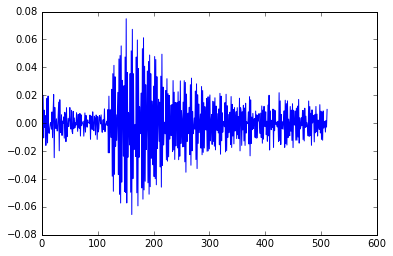

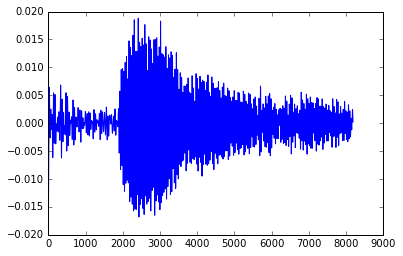

In [41]:
# wrap the method in our decorator from above, so that 
# things get shuttled between numpy and pytorch representations
# appropriately
wrapped_resample = pytorch_wrapper(pytorch_dct_resample)

# Now that we're computing the forward and inverse DCT transform
# in a naive, memory-intensive way, let's only resample a smaller
# segment of audio
sample_size = 8192
s = resample(samples, zounds.SR11025())[sample_size * 2:sample_size * 3]

upsampled = resample_evaluation(
    signal=s, 
    factor=0.0625, 
    downsample=wrapped_resample, 
    upsample=wrapped_resample)
Audio(upsampled, rate=int(s.samplerate))

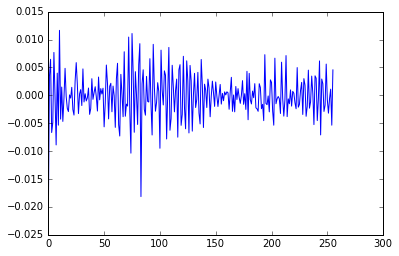

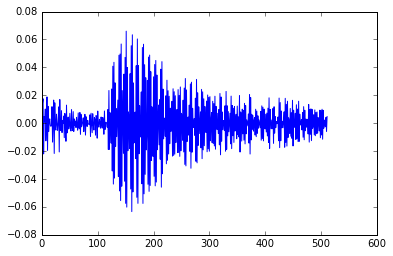

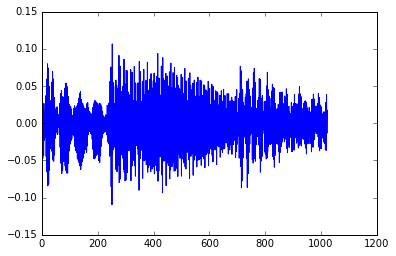

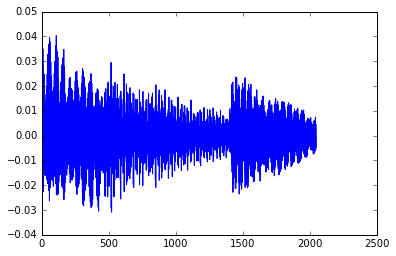

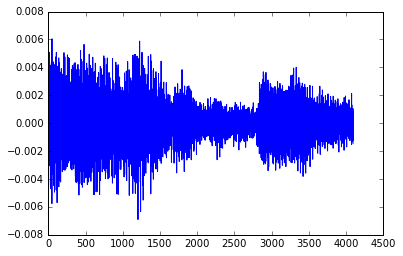

In [42]:

def pytorch_frequency_decomposition(x, factors, axis=-1):
    bands = []
    factors = sorted(factors)
    for f in factors:
        rs = pytorch_dct_resample(x, f, axis)
        bands.append(rs)
        us = pytorch_dct_resample(rs, (1./f), axis)
        x = x - us
    return bands

def pytorch_frequency_recomposition(bands, sample_size, axis=-1):
    shape = list(bands[0].shape)
    shape[axis] = sample_size
    upsampled = Variable(torch.zeros(*shape))
    
    for band in bands:
        factor = sample_size / band.shape[axis]
        us = pytorch_dct_resample(band, factor, axis)
        upsampled = upsampled + us
    
    return upsampled


Audio(s, rate=int(s.samplerate))
samplerate = s.samplerate
s = s.reshape((1, 1, sample_size)).astype(np.float32)
s = Variable(torch.from_numpy(s))


bands = pytorch_frequency_decomposition(s, [0.5, 0.25, 0.125, 0.0625, 0.03125])
for band in bands:
    plt.plot(band.data.cpu().numpy().squeeze())
    plt.show()
    
recon = pytorch_frequency_recomposition(bands, sample_size)
recon = recon.data.cpu().numpy().squeeze()

Audio(recon, rate=int(samplerate))        